### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading VOC dataset

This ipynotebook is modified from [qubvel\`s repo](https://github.com/qubvel/segmentation_models/tree/master/examples) to adjust to custom VOC-format dataset exported by [labelme](https://github.com/wkentaro/labelme).

In [6]:
import os
from os.path import join as pjoin
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

change the root dir to the one generated by labelme2voc.py

In [19]:
ROOT_DIR = pjoin('.','data','MyMasks')
img_dir = os.path.join(ROOT_DIR, 'JPEGImages')
mask_dir = os.path.join(ROOT_DIR, 'SegmentationClass')

#### Dataloader and utility functions 

In [20]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

#### Dataset Class for custom VOC-Format dataset
, merged some ideas from [meetshah1995](https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/pascal_voc_loader.py)

In [21]:
label_list = tuple(open(pjoin(ROOT_DIR,'class_names.txt'),'r'))
label_list = [c.strip() for c in label_list]
label_list = [c.strip('_') for c in label_list]
print(label_list)

['background', 'person', 'castle', 'table']


In [40]:
ids = os.listdir(img_dir)
filenames, exts = zip(*[os.path.splitext(image) for image in ids])
mask_ids = [filename+'.npy' for filename in filenames]
print(mask_ids)

['alterna.npy', 'paint.npy', 'party.npy', 'three.npy', 'ZHAO.npy']


In [41]:
class Dataset:
    """Custom VOC-FormatDataset. 
    Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    label_list = tuple(open(pjoin(ROOT_DIR,'class_names.txt'),'r'))
    label_list = [c.strip() for c in label_list]
    label_list = [c.strip('_') for c in label_list]
    CLASSES = label_list
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        # ids with .jpg extension
        self.ids = os.listdir(images_dir)
        ids = os.listdir(img_dir)
        filenames, exts = zip(*[os.path.splitext(image) for image in ids])
        self.mask_ids = [filename+'.npy' for filename in filenames]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.load(self.masks_fps[i])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

##### visualize one image in the dataset as example

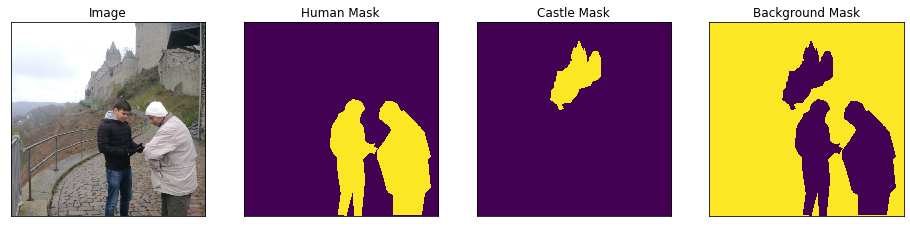

In [45]:
dataset = Dataset(img_dir, mask_dir, classes=['person','castle'])

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    human_mask=mask[..., 0].squeeze(),
    castle_mask=mask[..., 1].squeeze(),
    background_mask=mask[...,-1]
)

#### Dataloader class
used for stack the items in Dataset to create batch

In [46]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [47]:
import albumentations as A

In [60]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.Resize(320,320),

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32
    the voc dataset images have various resolution
    """
    test_transform = [
        A.Resize(320,320,interpolation=cv2.INTER_LINEAR)
        #A.PadIfNeeded(384, 480)
        #A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #A.RandomCrop(height=320, width=320, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

#### show some data after augmentation in the voc dataset

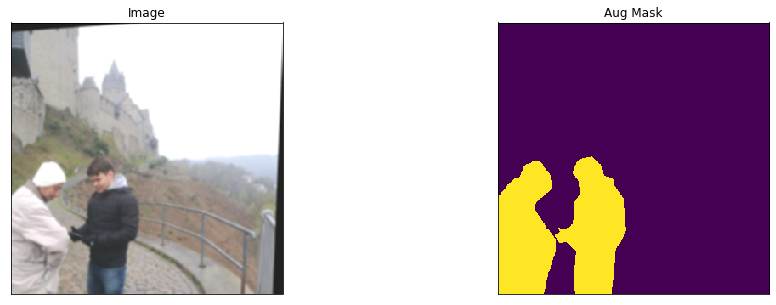

In [81]:
# Lets look at augmented data we have
dataset = Dataset(img_dir, mask_dir, classes=['person'], 
                  augmentation=get_training_augmentation())

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    aug_mask=mask[..., 0].squeeze(),
)

# Segmentation model training

In [83]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [84]:
BACKBONE = 'mobilenetv2'
BATCH_SIZE = 4
CLASSES = ['person']
LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [85]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#### create a new blank model

In [86]:
model = sm.Unet(BACKBONE,
                classes=n_classes,
                activation=activation,
               encoder_weights='imagenet',
               encoder_freeze=True)

C:\Users\zhaoc\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


#### create a model with pre-trained weights for retraining

In [22]:
model = sm.Unet(BACKBONE,
                classes=n_classes,
                activation=activation,
                weights='best_model_mobilnetv2.h5',
               encoder_weights='imagenet',
               encoder_freeze=True)

C:\Users\zhaoc\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [87]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

import json
model_json = model.to_json()
with open('efficientnet.json','w') as f:
    json.dump(model_json,f)

In [88]:
# Dataset for train images
train_dataset = Dataset(img_dir,
                        mask_dir,
                        classes=CLASSES,
                        augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

# Dataset for validation images
valid_dataset = Dataset(img_dir,
                        mask_dir,
                        classes=CLASSES,
                        augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
print('train img size:',train_dataloader[0][0].shape)
print('train mask size:',train_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
#weights_filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_mobilnetv2.h5',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

train img size: (4, 320, 320, 3)
train mask size: (4, 320, 320, 1)


In [89]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
1/1 [==============================] - 12s 12s/step - loss: 0.7228 - iou_score: 0.2402 - f1-score: 0.3873 - val_loss: 0.6810 - val_iou_score: 0.2601 - val_f1-score: 0.4023
Epoch 2/30
1/1 [==============================] - 7s 7s/step - loss: 0.7460 - iou_score: 0.2496 - f1-score: 0.3995 - val_loss: 0.7245 - val_iou_score: 0.3182 - val_f1-score: 0.4740
Epoch 3/30
1/1 [==============================] - 7s 7s/step - loss: 0.7405 - iou_score: 0.2679 - f1-score: 0.4226 - val_loss: 0.8309 - val_iou_score: 0.2756 - val_f1-score: 0.4250
Epoch 4/30
1/1 [==============================] - 7s 7s/step - loss: 0.7267 - iou_score: 0.2950 - f1-score: 0.4556 - val_loss: 0.5727 - val_iou_score: 0.3625 - val_f1-score: 0.5152
Epoch 5/30
1/1 [==============================] - 7s 7s/step - loss: 0.6392 - iou_score: 0.3176 - f1-score: 0.4820 - val_loss: 0.6957 - val_iou_score: 0.3717 - val_f1-score: 0.531

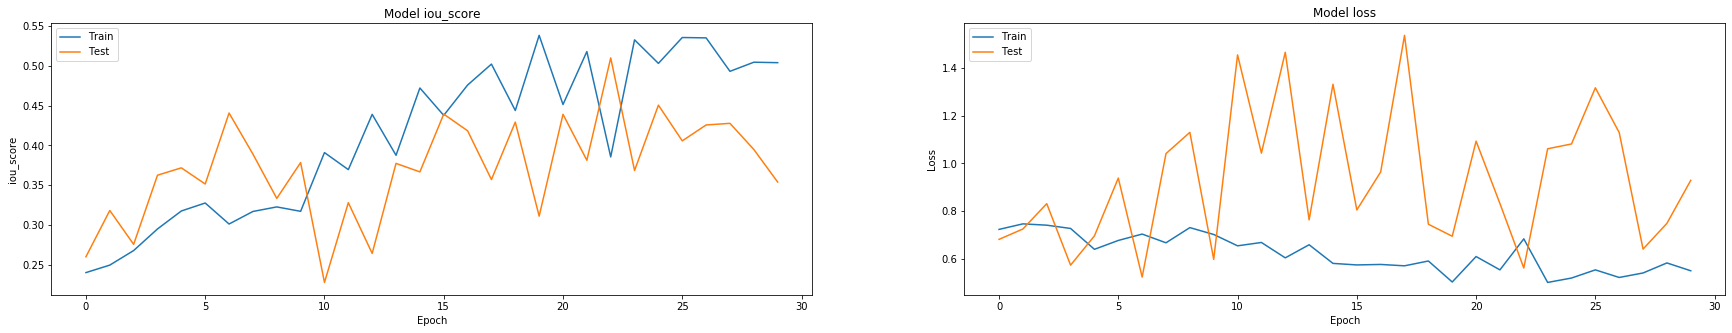

In [90]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [27]:
ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2007')

In [28]:

test_dataset = VOCDataset(ROOT_DIR,
                          'test',
                          classes=CLASSES,
                          augmentation=get_validation_augmentation(),
                          preprocessing=get_preprocessing(preprocess_input)
                         )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [29]:
# load best weights
model.load_weights('best_model_mobilnetv2.h5') 

In [30]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.28238
mean iou_score: 0.53807
mean f1-score: 0.64413


# Visualization of results on test dataset

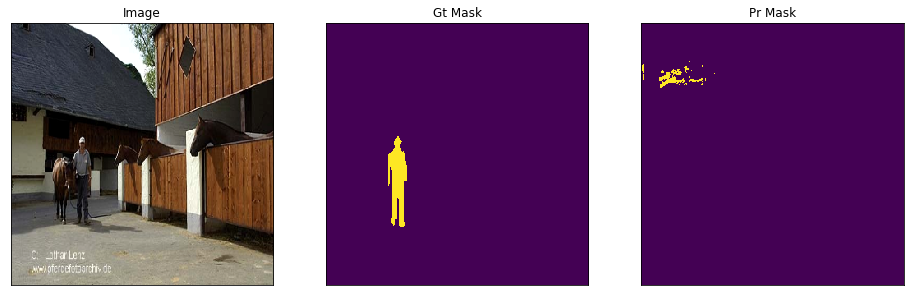

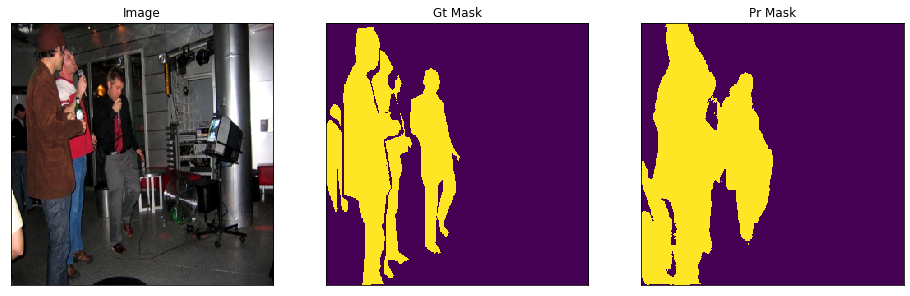

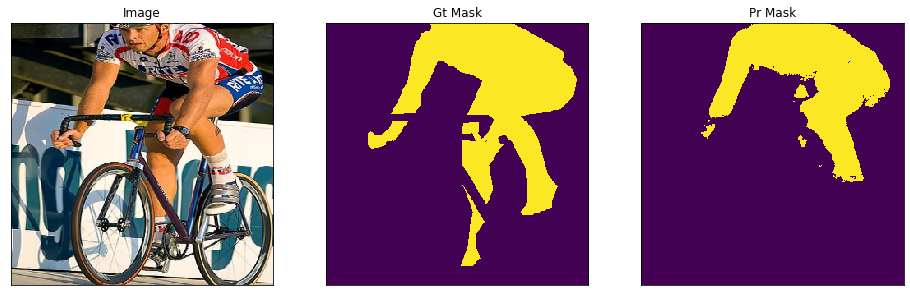

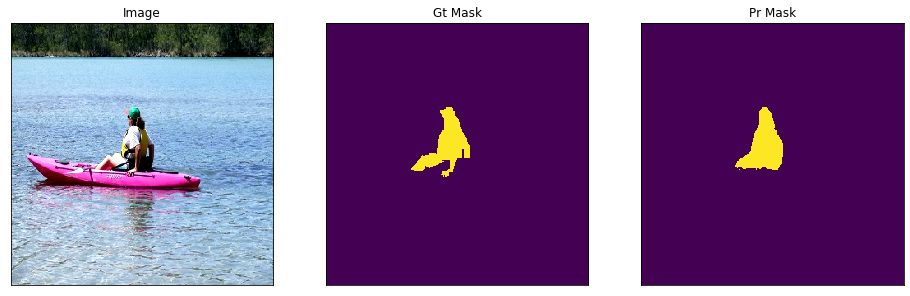

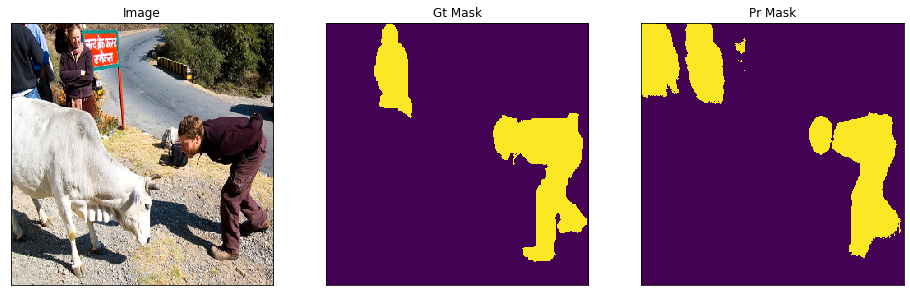

In [34]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

#### test the model with one own image

In [ ]:
image = cv2.imread('./data/MyImages/party.jpg')

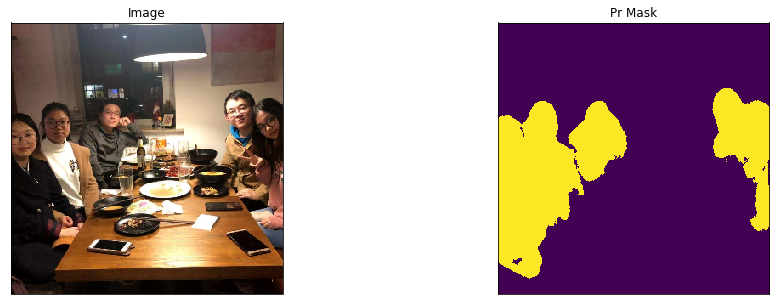

In [37]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
aug = get_validation_augmentation()
sample = aug(image=image)
image = sample['image']
pre = get_preprocessing(preprocess_input)
sample = pre(image=image)
image = sample['image']

image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image).round()
visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., 0].squeeze(),
    )